# Convert GLORYS12V1 data from PoteTemp/RelSal to ConsTem/AbsSal 

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import gsw as gs

%matplotlib inline

In [2]:
# Function to make plots 
def ctrl_plot(ds_inS,ds_inT,BDY): 
        # Control 2D the final result
        it=5 ; iz=10 

        plt.figure(figsize=(20,15))
        plt.subplot(231)
        ds_inS['vosaline'].isel(time_counter=it,z=iz).plot(vmin=BDY['Sxymin'],vmax=BDY['Sxymax'],cmap='Spectral_r')
        plt.title('PSU')

        plt.subplot(232)
        ds_inS['SA'].isel(time_counter=it,z=iz).plot(vmin=BDY['Sxymin'],vmax=BDY['Sxymax'],cmap='Spectral_r')
        plt.title('SA')

        plt.subplot(233)
        (ds_inS['SA'].isel(time_counter=it,z=iz)-ds_inS['vosaline'].isel(time_counter=it,z=iz)).plot(vmin=-.2,vmax=.2,cmap='seismic')
        plt.title('SA-PSU')

        plt.subplot(234)
        ds_inT['votemper'].isel(time_counter=it,z=iz).plot(vmin=BDY['Txymin'],vmax=BDY['Txymax'],cmap='Spectral_r')
        plt.title('Theta')

        plt.subplot(235)
        ds_inT['CT'].isel(time_counter=it,z=iz).plot(vmin=BDY['Txymin'],vmax=BDY['Txymax'],cmap='Spectral_r')
        plt.title('CT')

        plt.subplot(236)
        (ds_inT['CT'].isel(time_counter=it,z=iz)-ds_inT['votemper'].isel(time_counter=it,z=iz)).plot(vmin=-.02,vmax=.02,cmap='seismic')
        plt.title('CT-Theta')


        # Control the final result along a given longitude
        it=BDY['it_sec'] ; iz=BDY['iz_sec'] ; ix=BDY['ix_sec']

        plt.figure(figsize=(20,15))
        plt.subplot(221)
        ds_inS['vosaline'].isel(time_counter=it,z=iz,x=ix).plot(label='PS',x='nav_lat')
        ds_inS['SA'].isel(time_counter=it,z=iz,x=ix).plot(label='SA',x='nav_lat')
        plt.ylim([BDY['Sxymin'],BDY['Sxymax']])
        plt.grid(True)
        plt.legend()

        plt.subplot(222)
        (ds_inS['SA'].isel(time_counter=it,z=iz,x=ix)-ds_inS['vosaline'].isel(time_counter=it,z=iz,x=ix)).plot(x='nav_lat')
        plt.grid(True)
        plt.legend()

        plt.subplot(223)
        ds_inT['votemper'].isel(time_counter=it,z=iz,x=ix).plot(label='pt',x='nav_lat')
        ds_inT['CT'].isel(time_counter=it,z=iz,x=ix).plot(label='CT',x='nav_lat')
        plt.ylim([BDY['Txymin'],BDY['Txymax']])
        plt.grid(True)
        plt.legend()

        plt.subplot(224)
        (ds_inT['CT'].isel(time_counter=it,z=iz,x=ix)-ds_inT['votemper'].isel(time_counter=it,z=iz,x=ix)).plot(x='nav_lat')
        plt.grid(True)
        plt.legend()

        # Control the final result over time at a grid point 
        ix=BDY['ix_time'] ; iy=BDY['iy_time'] ; iz=BDY['iz_time']

        plt.figure(figsize=(20,15))
        plt.subplot(221)
        ds_inS['vosaline'].isel(x=ix,y=iy,z=iz).plot(label='PS',x='time_counter')
        ds_inS['SA'].isel(x=ix,y=iy,z=iz).plot(label='SA',x='time_counter')
        plt.ylim([BDY['Stsmin'],BDY['Stsmax']])
        plt.grid(True)
        plt.legend()

        plt.subplot(222)
        (ds_inS['SA'].isel(x=ix,y=iy,z=iz)-ds_inS['vosaline'].isel(x=ix,y=iy,z=iz)).plot(x='time_counter')
        plt.grid(True)
        plt.legend()

        plt.subplot(223)
        ds_inT['votemper'].isel(x=ix,y=iy,z=iz).plot(label='pt',x='time_counter')
        ds_inT['CT'].isel(x=ix,y=iy,z=iz).plot(label='CT',x='time_counter')
        plt.ylim([BDY['Ttsmin'],BDY['Ttsmax']])
        plt.grid(True)
        plt.legend()

        plt.subplot(224)
        (ds_inT['CT'].isel(x=ix,y=iy,z=iz)-ds_inT['votemper'].isel(x=ix,y=iy,z=iz)).plot(x='time_counter')
        plt.grid(True)
        plt.legend()



In [3]:
# Function to transform a depth vector into a 4D field
def Z4D(ds_in):
        
        # Need also to provide a depth in 4D
        depth=ds_in['deptht']
        depth.shape

        # Prepare this 1D field to be duplicated 
        z2dt=np.reshape(depth.values,(1,ds_in.dims['z'],1,1))
        z2dt.shape
        zplt = np.repeat(z2dt,ds_in.dims['time_counter'],axis=0)
        zplt.shape

        # Duplicate this depth to fit the T/S on a global grid
        depth4D=np.tile(zplt,(1,1,ds_in.dims['y'],ds_in.dims['x']))
        depth4D.shape
                
        return depth4D

>>>>>> # FUNCTIONS END

In [4]:
# Set specific cont. locations for control for each BDY
bdy_Bering={'name':'BERING',\
            'Sxymin':32.,'Sxymax': 33.,'Txymin':-3.,'Txymax':1.,\
            'Stsmin':30.,'Stsmax': 33.,'Ttsmin':-2.,'Ttsmax':8.,\
            'it_sec':5,'iz_sec':15,'ix_sec':20,\
            'iz_time':0,'ix_time':20,'iy_time':4} 

bdy_SubTro={'name':'SUBTROPGYRE',\
            'Sxymin':36.,'Sxymax': 38.,'Txymin':20.,'Txymax':28.,\
            'Stsmin':36.,'Stsmax': 38.,'Ttsmin':20.,'Ttsmax':28.,\
            'it_sec':5,'iz_sec':15,'ix_sec':400,\
            'iz_time':0,'ix_time':400,'iy_time':4} 

In [22]:
# Perform or not the plot control & do the Netcdf output as well
#plot_check=True
plot_check=True
outNCDF=False

In [5]:
# Set the year range 
year_s=2020
year_e=2020

In [6]:
# Select the BDY type 
BDY=bdy_Bering
#BDY=bdy_SubTro

>>>> # UNITS CONVERSION

In [7]:
INDIR='/data0/project/drakkar/CONFIGS/CREG12.L75/FORCING/GLORYS12V1-BDYS/'+BDY['name']+'/'

# Read the Potential temperature & Practical salinity original fields 

In [8]:
doit_once=False # To compute only the first year

for year in np.arange(year_s,year_e+1):
    
    print(" >>>>>>>>   Treat year: ",year)
    print()

    ds_inT=xr.open_mfdataset(INDIR+str(year)+'/GLORYS12V1-CREG12.L75_'+BDY['name']+'_y'+str(year)+'.1d_gridT.nc')
    ds_inS=xr.open_mfdataset(INDIR+str(year)+'/GLORYS12V1-CREG12.L75_'+BDY['name']+'_y'+str(year)+'.1d_gridS.nc')
    ds_inT
    #ds_inS

    # Define a 4D depth field 
    if doit_once :
        depth4D= Z4D(ds_inT)     
        #doit_once=False



 >>>>>>>>   Treat year:  2020



/opt/linux/envs/envs/phyocean-2023.05/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'votemper' has multiple fill values {0.0, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/linux/envs/envs/phyocean-2023.05/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'vosaline' has multiple fill values {0.0, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [9]:
ds_inT

<xarray.Dataset>
Dimensions:       (z: 75, y: 10, x: 42, time_counter: 366)
Coordinates:
    deptht        (z) float64 dask.array<chunksize=(75,), meta=np.ndarray>
    nav_lat       (y, x) float64 dask.array<chunksize=(10, 42), meta=np.ndarray>
    nav_lon       (y, x) float64 dask.array<chunksize=(10, 42), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2020-01-01T12:00:00 ... 2020-...
Dimensions without coordinates: z, y, x
Data variables:
    votemper      (time_counter, z, y, x) float32 dask.array<chunksize=(366, 75, 10, 42), meta=np.ndarray>
Attributes:
    Info:                      Horizontal grid read in CREG12.L75_domain_cfg_...
    About:                     Created with SOSIE interpolation environement ...
    nco_openmp_thread_number:  1
    history:                   Wed Feb 22 17:27:45 2023: ncpdq -a -x BERING_y...
    NCO:                       "4.6.4"

>>> ### Define an ocean/land mask based on the salinity 

In [10]:
Smask=xr.where(np.isnan(ds_inS),0.,1.)

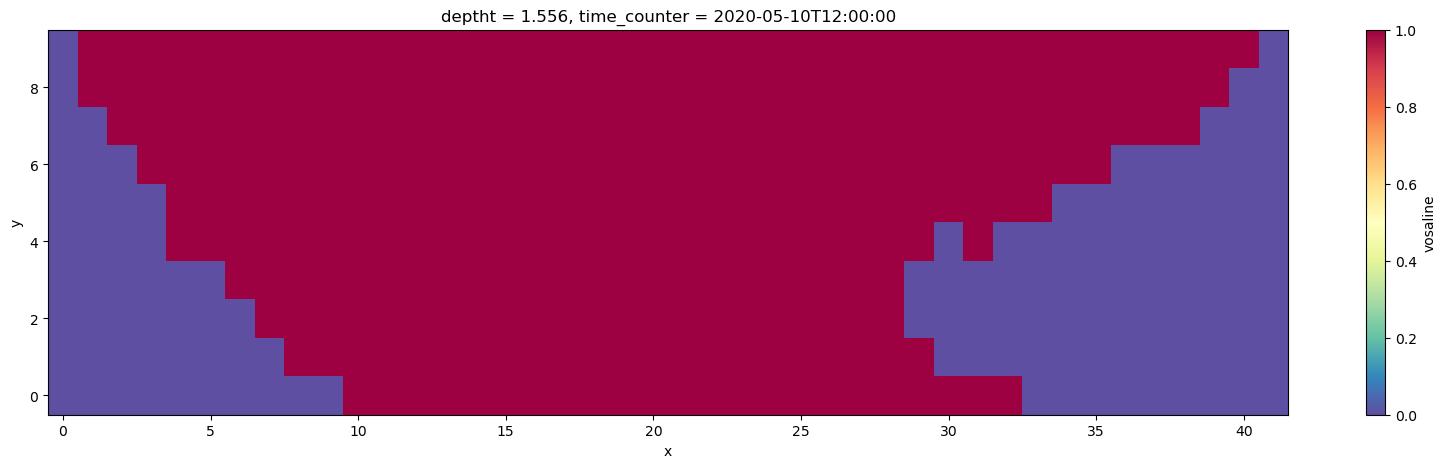

In [11]:
plt.figure(figsize=(20,5))
ax=Smask.vosaline.sel(time_counter="2020-05-10").isel(z=1).plot(cmap='Spectral_r')

>>> ### Plot few frame to control the changes 

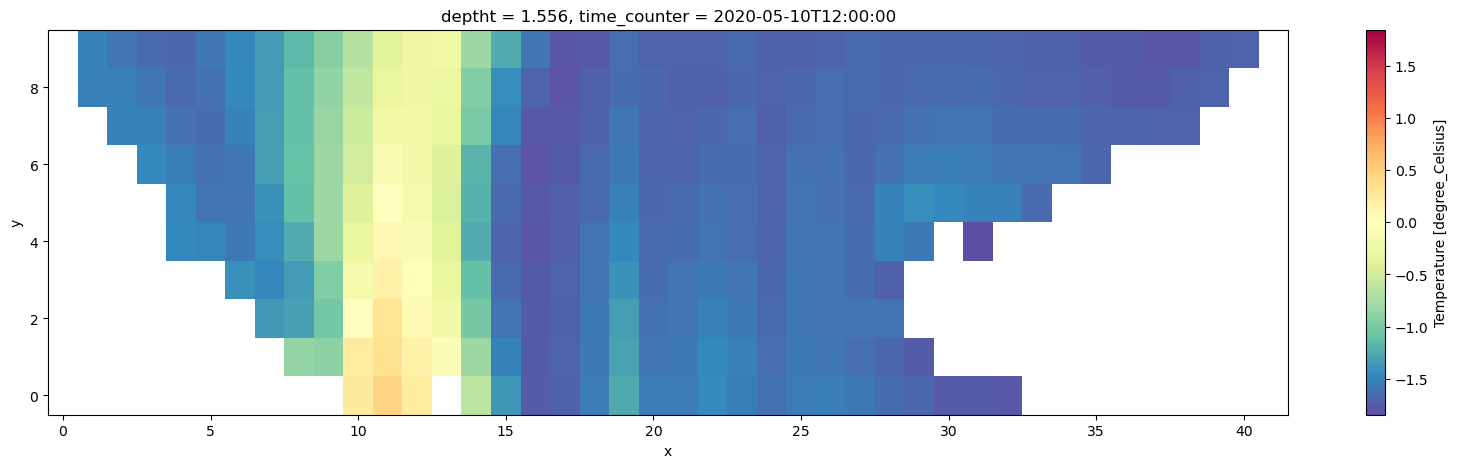

In [13]:
plt.figure(figsize=(20,5))
ax=ds_inT.votemper.sel(time_counter="2020-05-10").isel(z=1).plot(cmap='Spectral_r')

>>> ### Set grid-land points to 99699 and let others grid-ocean points to NaN

In [14]:
ds_inT=xr.where(Smask.vosaline == 0.,99699, ds_inT ) 

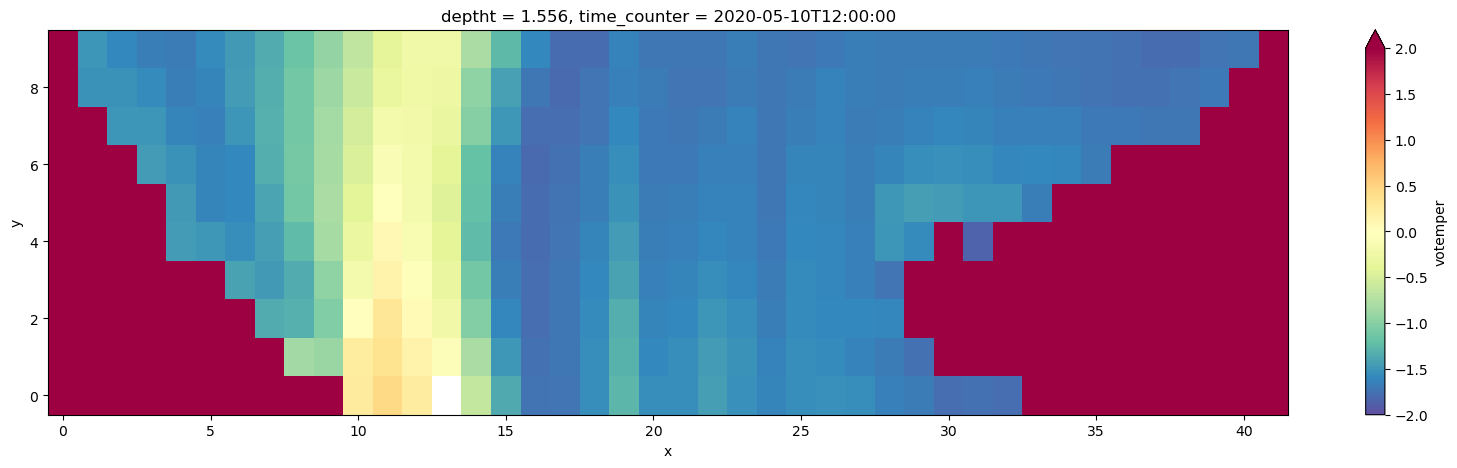

In [15]:
plt.figure(figsize=(20,5))
ax=ds_inT.votemper.sel(time_counter="2020-05-10").isel(z=1).plot(cmap='Spectral_r',vmin=-2.,vmax=2.)

>>> ### Then convert remaining ocean Nan to a smal CT value 10^-4 (because originally a tiny value ~10^-4 or 10^-5 exist)

In [16]:
ds_inT=xr.where(np.isnan(ds_inT),1.e-5, ds_inT ) 

>>> ### Set grid-land points with NaN

In [17]:
ds_inT=xr.where(Smask.vosaline == 0.,np.nan, ds_inT ) 

>>>  ### Control plots

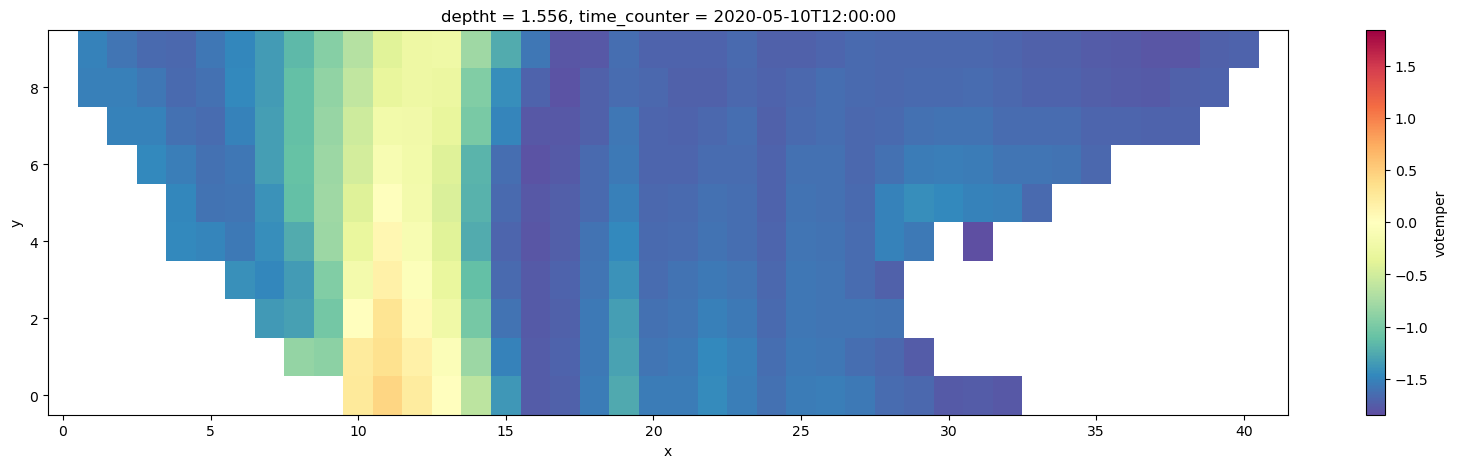

In [18]:
plt.figure(figsize=(20,5))
ax=ds_inT.votemper.sel(time_counter="2020-05-10").isel(z=1).plot(cmap='Spectral_r')

# Save the new dataset with corrections 

In [19]:
ds_inT_ref=xr.open_mfdataset(INDIR+str(year)+'/GLORYS12V1-CREG12.L75_'+BDY['name']+'_y2020.1d_gridT.nc')

/opt/linux/envs/envs/phyocean-2023.05/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'votemper' has multiple fill values {0.0, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [20]:
ds_inT_ref

<xarray.Dataset>
Dimensions:       (z: 75, y: 10, x: 42, time_counter: 366)
Coordinates:
    deptht        (z) float64 dask.array<chunksize=(75,), meta=np.ndarray>
    nav_lat       (y, x) float64 dask.array<chunksize=(10, 42), meta=np.ndarray>
    nav_lon       (y, x) float64 dask.array<chunksize=(10, 42), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2020-01-01T12:00:00 ... 2020-...
Dimensions without coordinates: z, y, x
Data variables:
    votemper      (time_counter, z, y, x) float32 dask.array<chunksize=(366, 75, 10, 42), meta=np.ndarray>
Attributes:
    Info:                      Horizontal grid read in CREG12.L75_domain_cfg_...
    About:                     Created with SOSIE interpolation environement ...
    nco_openmp_thread_number:  1
    history:                   Wed Feb 22 17:27:45 2023: ncpdq -a -x BERING_y...
    NCO:                       "4.6.4"

 >>>>>>>>   Treat year:  2020



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


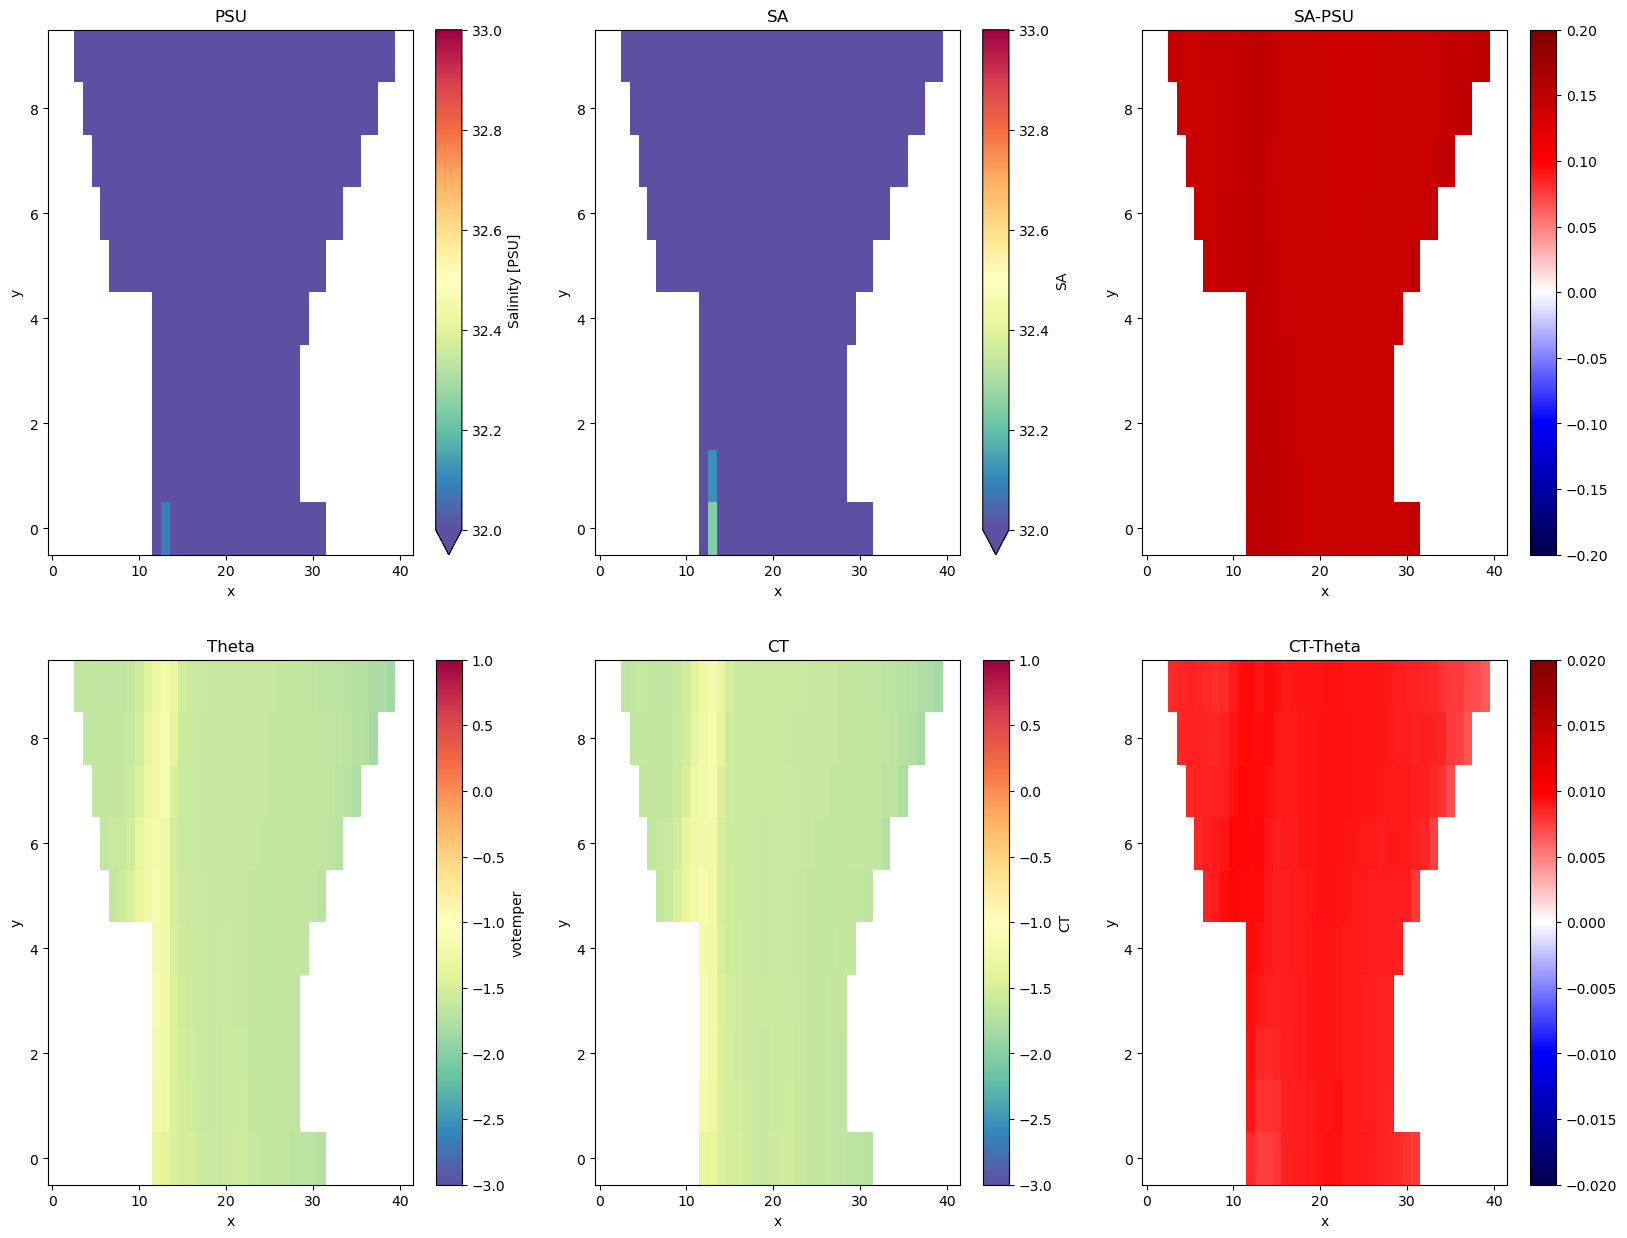

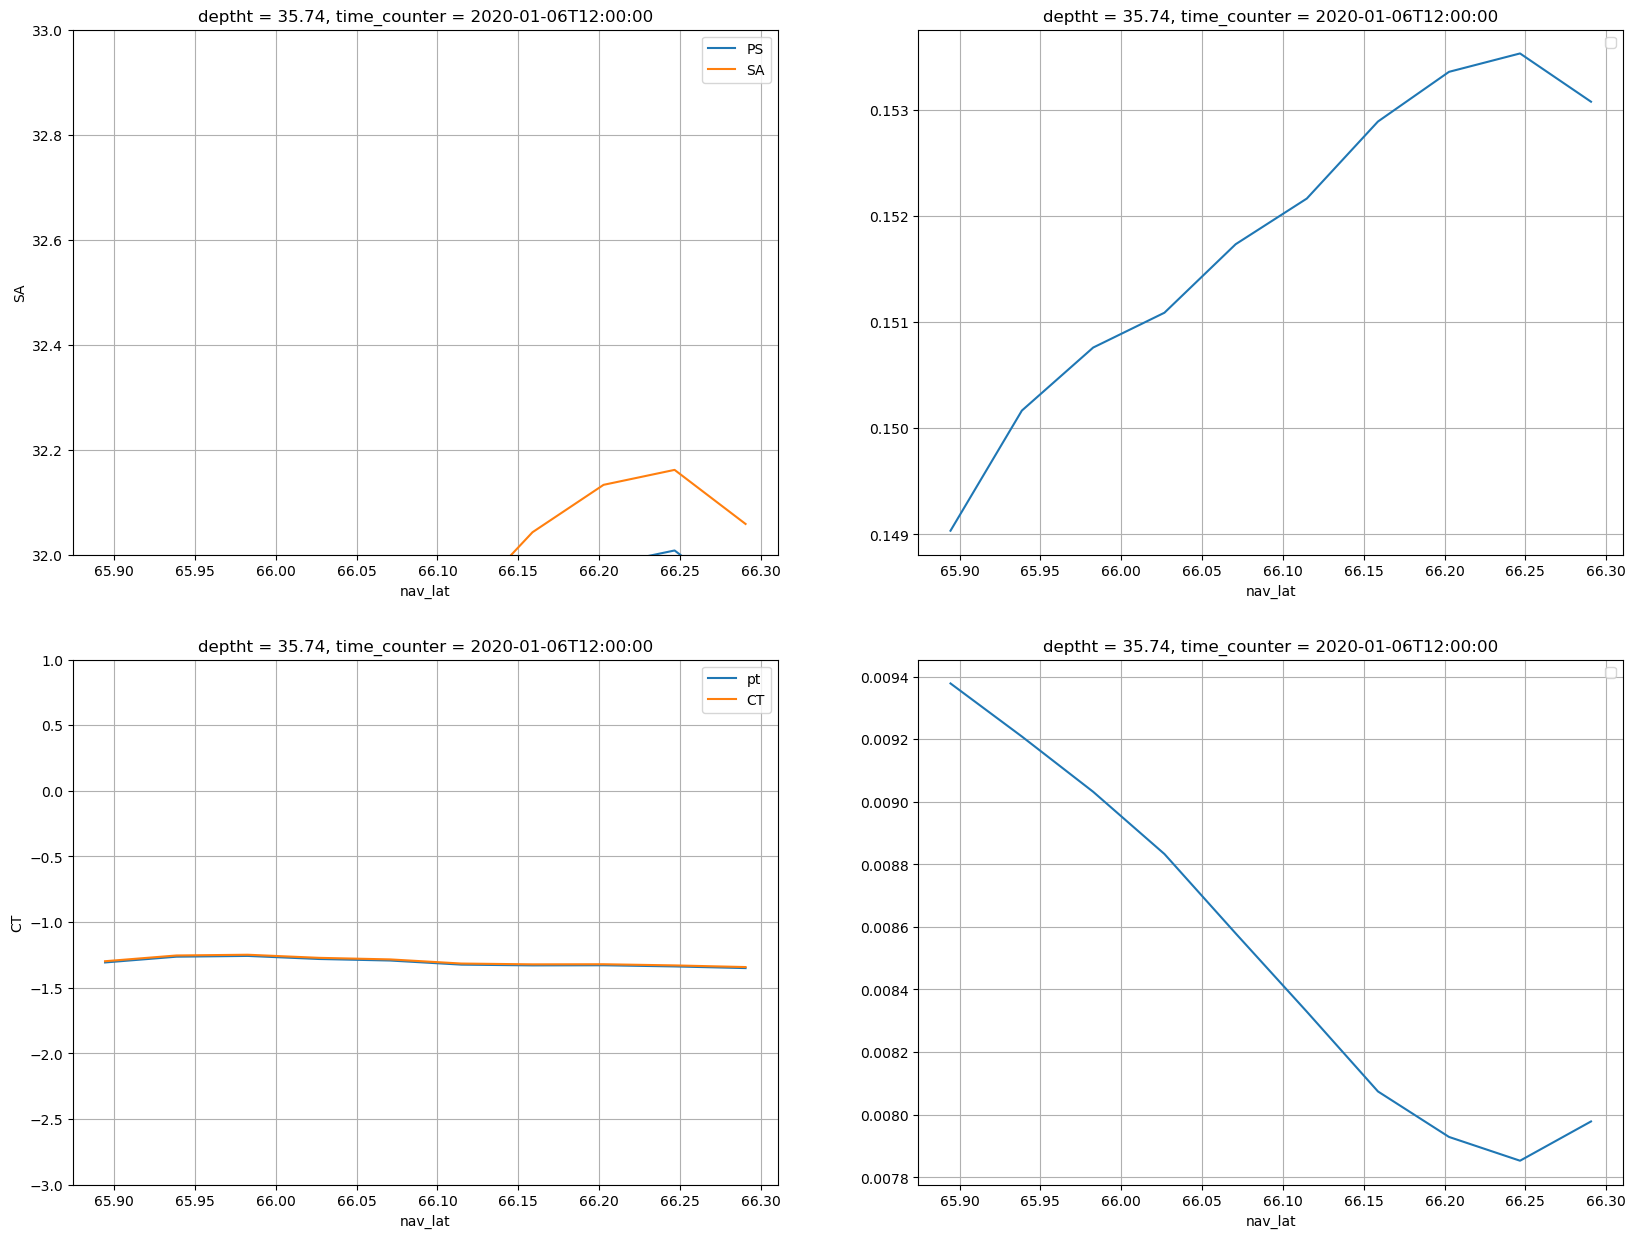

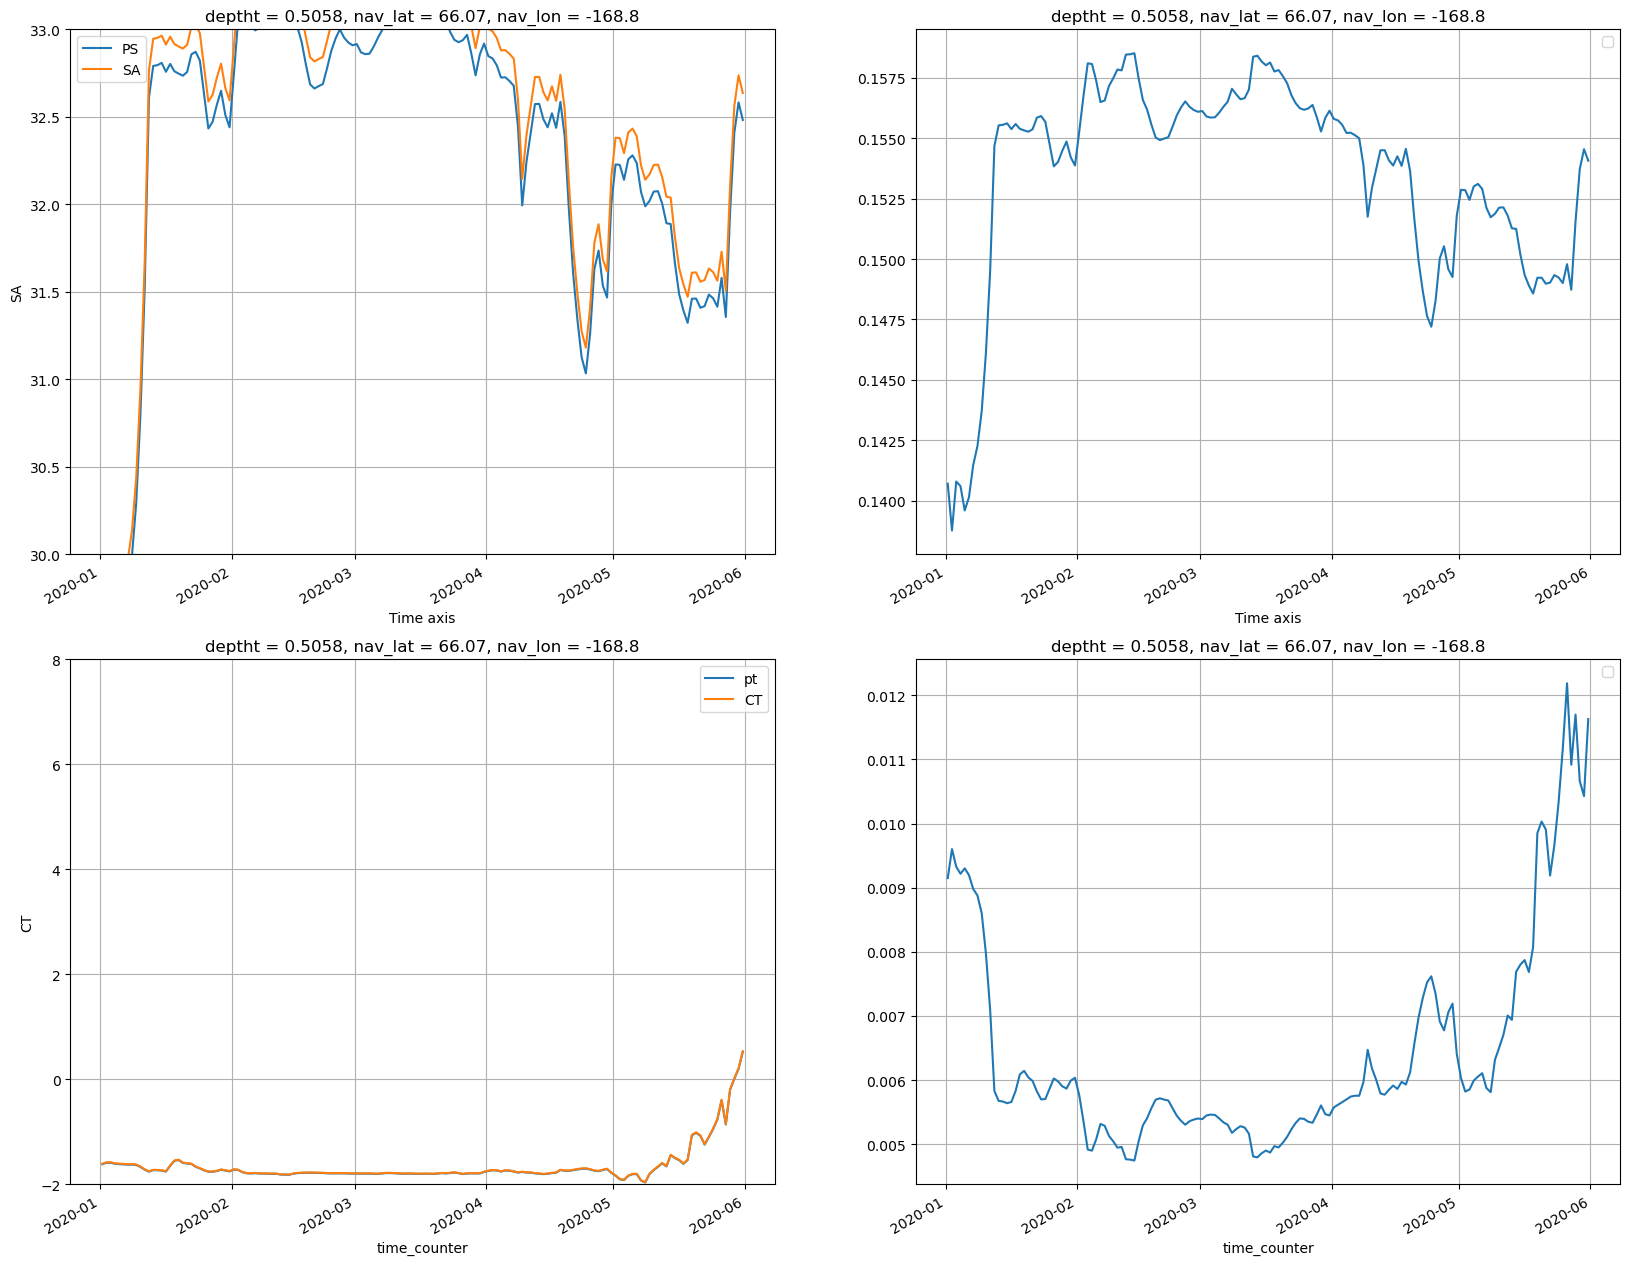

In [23]:
doit_once=True # To compute only the first year

for year in np.arange(year_s,year_e+1):
    
    print(" >>>>>>>>   Treat year: ",year)
    print()

    #ds_inT=xr.open_mfdataset(INDIR+str(year)+'/GLORYS12V1-CREG12.L75_'+BDY['name']+'_y'+str(year)+'.1d_gridT.nc')
    #ds_inS=xr.open_mfdataset(INDIR+str(year)+'/GLORYS12V1-CREG12.L75_'+BDY['name']+'_y'+str(year)+'.1d_gridS.nc')
    # Use the temperature field corrected & the salinity one
    ds_inT
    ds_inS

    # Define a 4D depth field 
    if doit_once :
        depth4D= Z4D(ds_inT)     
        #doit_once=False

    # Apply the conversion
    # Get the Absolute Salinity SA first 
    # Then compute the conservative temperature CT 
    #########    #########    #########    #########    #########    #########    #########    #########    #########
    ds_SA=gs.conversions.SA_from_SP(ds_inS['vosaline'],depth4D,ds_inS['nav_lon'],ds_inS['nav_lat'] )
    ds_CT=gs.conversions.CT_from_pt(ds_SA,ds_inT['votemper'].values)
    ds_CT.shape

    ds_inS['SA']=(('time_counter','z','y','x'),ds_SA.values)
    ds_inT['CT']=(('time_counter','z','y','x'),ds_CT.values)
    
    # Make plots to control the results
    #########    #########    #########    #########    #########    #########    #########    #########    #########
    if plot_check: ctrl_plot(ds_inS,ds_inT,BDY)

    # Output final fields
    #########    #########    #########    #########    #########    #########    #########    #########    #########
    if True :
        OUTDIR='/data0/project/drakkar/CONFIGS/CREG12.L75/FORCING/GLORYS12V1-BDYS/'+BDY['name']+'/'

        ds_out=xr.Dataset()
        # Save Absolute Salinity 
        ds_out['SA']=(('time_counter','z','y','x'),ds_inS['SA'].values)
        ds_out['SA'].attrs['units']='g/kg'
        ds_out['SA'].attrs['long_name']='Absolute salinity'
        ds_out['SA'].attrs['standard_name']=ds_inS['vosaline'].attrs['standard_name']
        ds_out['SA'].attrs['short_name']='SA'
        ds_out.coords['nav_lat']=(('y','x'),ds_inS['nav_lat'].values)
        ds_out.coords['nav_lon']=(('y','x'),ds_inS['nav_lon'].values)
        ds_out.coords['deptht']=(('z'),ds_inS['deptht'].values)
        ds_out.coords['time_counter']=(('time_counter'),ds_inS['time_counter'].values)
        ds_out.attrs=ds_inS.attrs
        file_out_SA=OUTDIR+str(year)+'/GLORYS12V1-CREG12.L75_'+BDY['name']+'_y'+str(year)+'.1d_gridSA.nc'
        ds_out.to_netcdf(file_out_SA,encoding={'nav_lat':{'dtype':'float32'},'nav_lon':{'dtype':'float32'},\
                                               'deptht':{'dtype':'float32'},\
                                               'SA':{'dtype':'float32'}},\
                         unlimited_dims='time_counter')

        ds_out=xr.Dataset()
        # Save Conservative temperature
        ds_out['CT']=(('time_counter','z','y','x'),ds_inT['CT'].values)
        ds_out['CT'].attrs['units']=ds_inT_ref['votemper'].attrs['units']
        ds_out['CT'].attrs['long_name']='Conservative temperature'
        ds_out['CT'].attrs['standard_name']=ds_inT_ref['votemper'].attrs['standard_name']
        ds_out['CT'].attrs['short_name']='CT'
        ds_out.coords['nav_lat']=(('y','x'),ds_inT_ref['nav_lat'].values)
        ds_out.coords['nav_lon']=(('y','x'),ds_inT_ref['nav_lon'].values)
        ds_out.coords['deptht']=(('z'),ds_inT_ref['deptht'].values)
        ds_out.coords['time_counter']=(('time_counter'),ds_inT_ref['time_counter'].values)
        ds_out.attrs=ds_inT.attrs
        file_out_CT=OUTDIR+str(year)+'/GLORYS12V1-CREG12.L75_'+BDY['name']+'_y'+str(year)+'.1d_gridCT.nc'
        ds_out.to_netcdf(file_out_CT,encoding={'nav_lat':{'dtype':'float32'},'nav_lon':{'dtype':'float32'},\
                                               'deptht':{'dtype':'float32'},\
                                               'CT':{'dtype':'float32'}},\
                        unlimited_dims='time_counter')

        # Compress the new data set
        !ncks -4 -L 1 -O {file_out_SA} {file_out_SA} 
        !ncks -4 -L 1 -O {file_out_CT} {file_out_CT}


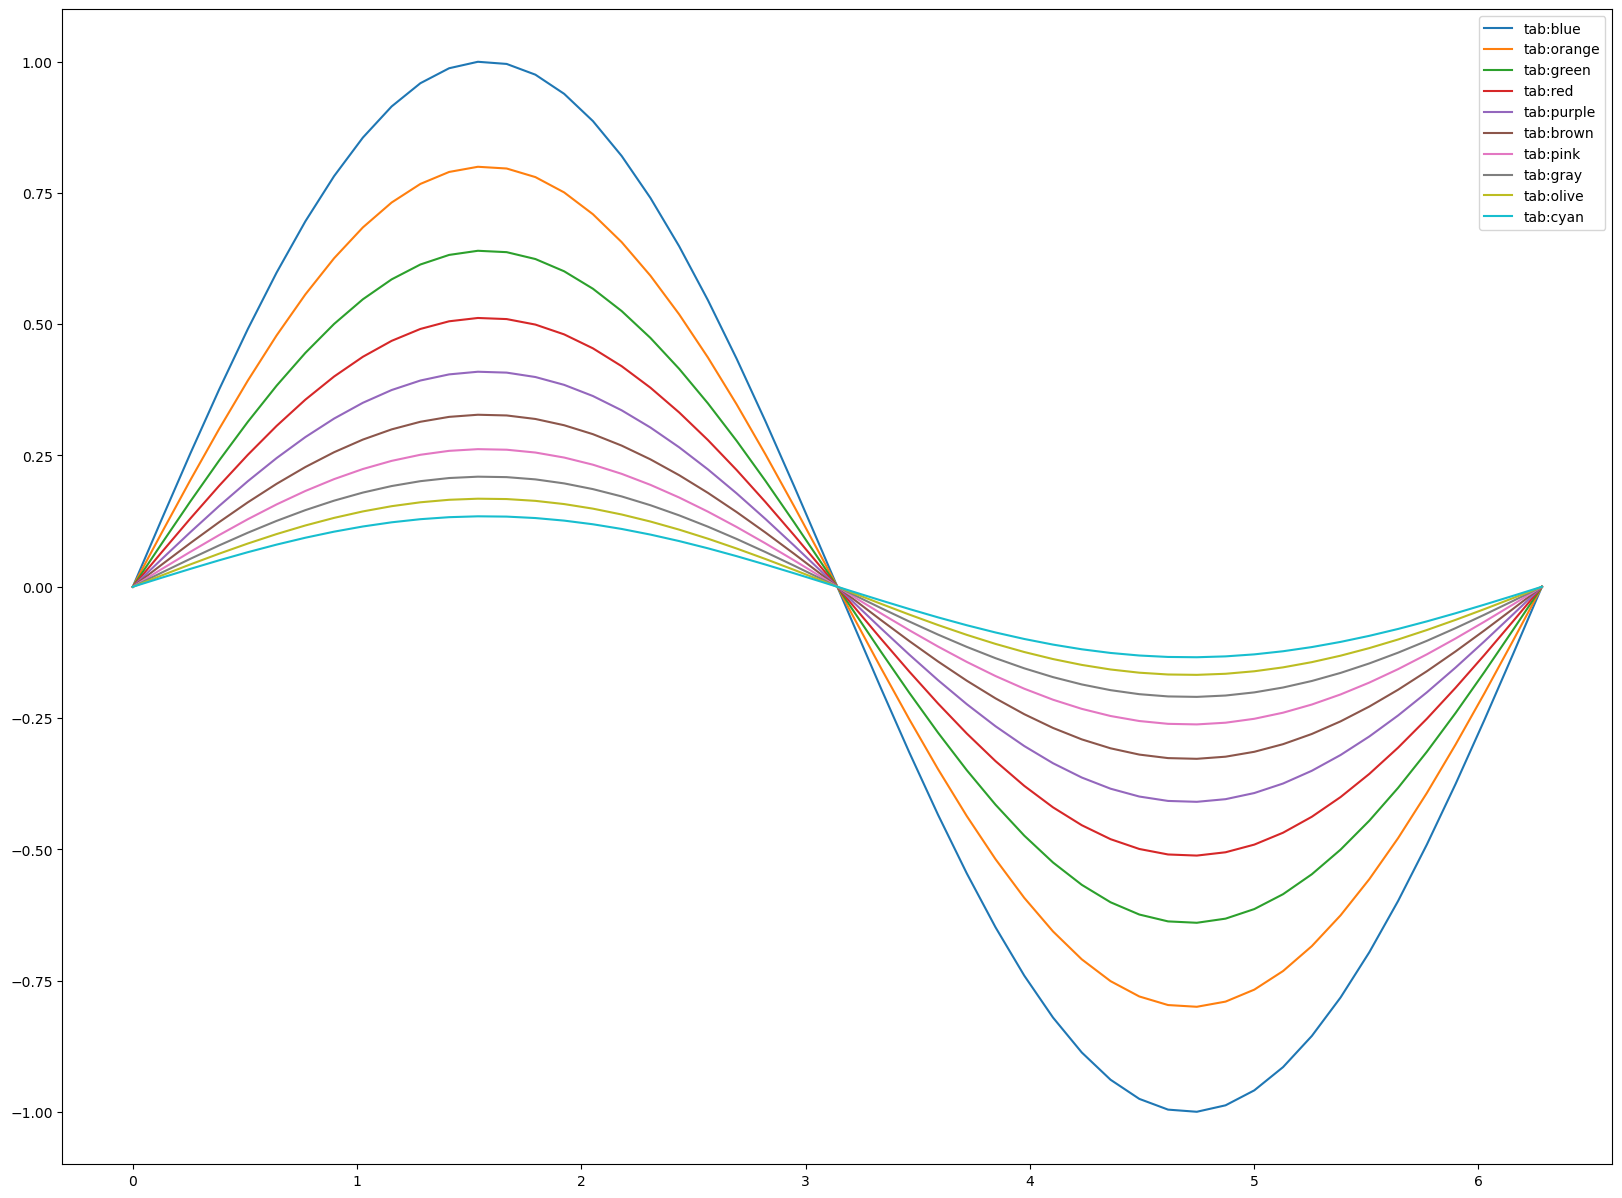

In [113]:
import matplotlib.colors as mcolors

x = np.linspace(0, 2*np.pi)
y = np.sin(x)

mcolors.TABLEAU_COLORS

plt.figure(figsize=(20,15))
A = 1.
for color in mcolors.TABLEAU_COLORS:
    plt.plot(x, A * y, c=color, label=color)
    A *= 0.8
plt.legend()

>>>>>>